In [ ]:
from IPython.display import Image, display

### Оптимизация декодирования



#### MoE - Mixture of Experts

MoE — это архитектурный подход в глубоком обучении, который позволяет увеличить ёмкость модели без пропорционального роста вычислительных затрат.

Основная идея - разные части входных данных обрабатываются разными "экспертами" (подмоделями), а решение о выборе экспертов принимает "маршрутизатор" (router)

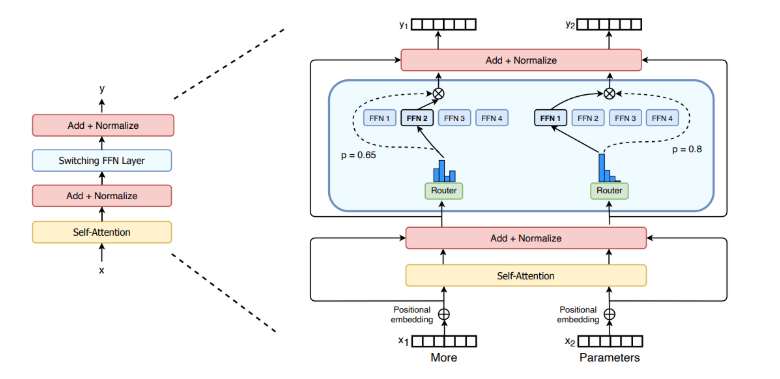

**Эксперты** - независимые нейросетевые модули (обычно FFN)

**Router** - небольшая нейросеть (часто линейный слой + softmax), которая решает, каким экспертам отправить входные данные. На выходе роутера — вероятностное распределение над экспертами.

Активируются только выбранные эксперты, остальные "спят" — это экономит ресурсы.

Примерный пайплайн работы:

- Токен (или набор токенов) проходит через self-attention
- Для каждого токена router предсказывает топ-k экспертов (обычно k=1 или 2)
- Токен обрабатывается только выбранными экспертами, их выходы взвешиваются
- Результаты экспертов суммируются и передаются дальше по сети


```python
class MoELayer(nn.Module):
    def __init__(self, num_experts, hidden_size):
        self.experts = nn.ModuleList([FeedForward(hidden_size) for _ in range(num_experts)])
        self.router = nn.Linear(hidden_size, num_experts)

    def forward(self, x):
        # Шаг 1: Маршрутизация
        logits = self.router(x)
        probs = torch.softmax(logits, dim=-1)
        top_k_probs, top_k_indices = torch.topk(probs, k=2)

        # Шаг 2: Активация экспертов
        output = torch.zeros_like(x)
        for i, expert_idx in enumerate(top_k_indices):
            expert_output = self.experts[expert_idx](x[i])
            output[i] = expert_output * top_k_probs[i]

        return output
```

#### KV-Cache

KV-Cache (Key-Value Cache) —  оптимизация, используемая в трансформерных моделях для ускорения процесса генерации последовательностей в авторегрессионном режиме

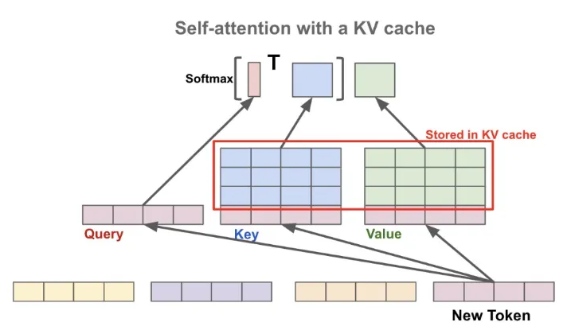

KV-Cache хранит ключи и значения, сгенерированные предыдущими токенами. Это позволяет снизить временную сложность с квадратичной до линейной. Однако использование KV-Cache увеличивает использование памяти GPU, что создает новое узкое место.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
%%timeit

model.generate(**tokenizer("What is KV caching?", return_tensors="pt").to(device), use_cache=True, max_new_tokens=1000)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


10.2 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

model.generate(**tokenizer("What is KV caching?", return_tensors="pt").to(device), use_cache=False, max_new_tokens=1000)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


45.8 s ± 384 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[KV cache strategies](https://huggingface.co/docs/transformers/kv_cache)

#### Speculative Decoding



При генерации токенов LLM имеет две стадии:

- **Prefill** - обработка контекста и заполнение KVCache - Compute-bound задача

- **Decode** - генерация новых токенов авторегрессионно: сгенерировали токен, добавили к текущему накопленному промпту, повторили, пока не сгенерируем нужное количество - Memory-bound задача

При увеличении размера генерации происходит очень много forward вычислений на каждый новый токен, что не эффективно

##### Speculative Sampling

[Speculative Sampling GitHub](https://github.com/shreyansh26/Speculative-Sampling/blob/main/speculative_sampling.py)

**Терминология**

Основная (target) модель — большая и точная, но медленная (например, GPT-4)

Черновая (draft) модель — маленькая и быстрая (например, distilled модель )


Сгенерируем наперед авторегрессионно токены с помощью draft модели (спекуляция). После этого за один forward прогоним сгенерированные токены через target модель. Таким образом имеем для каждого токена вероятности $q(x)$ для драфт модели и $p(x)$ для этих же токенов от основной модели.

Теперь, вместо семплирования $x∼p(x)$:

- Семплируем $x∼q(x)$

- Если $q(x) ≤ p(x)$ принимаем спекулятивный токен

- Если $q(x) > p(x)$, то отклоняем его с вероятностью $1 − p(x)/q(x)$

- В случае отклонения семплируем x из распределения $norm(max(0, p(x) − q(x)))$

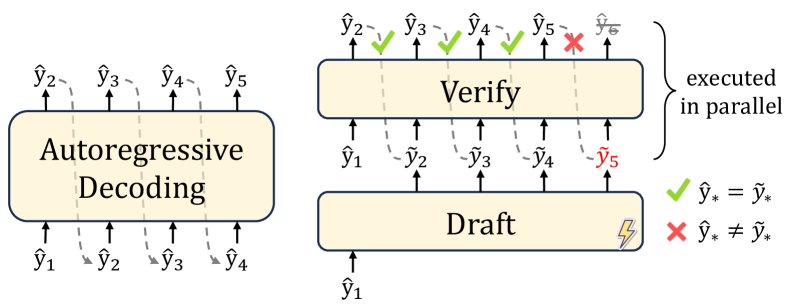

##### Multitoken prediction

Идея - пусть модель сама на каждый токен генерирует несколько вариантов, и потом выберем из них

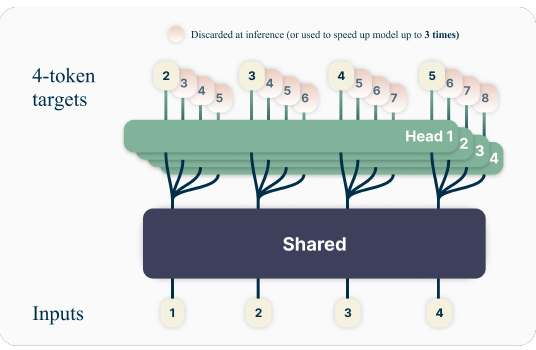

[Better & Faster Large Language Models via Multi-token Prediction](https://arxiv.org/pdf/2404.19737)

##### Medusa

[Medusa GitHub](https://github.com/FasterDecoding/Medusa)

Добавим к LMHead (классификационной голове) еще несколько голов, генерирующующих токены наперед, и будем дообучать только их.

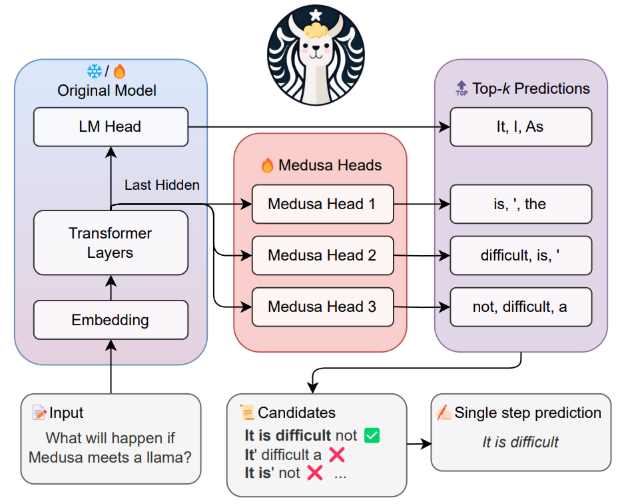

При дополнении LLM головами с помощью Medusa исходная модель остается нетронутой. Во время генерации каждая из этих голов производит несколько вероятных токенов для соответствующей позиции. Затем эти варианты объединяются и обрабатываются с использованием механизма внимания на основе дерева. Наконец, используется типичная схема принятия для выбора самого длинного правдоподобного префикса из кандидатов для дальнейшего декодирования.

### Увеличение контекста и эффективности в современных моделях

Основные способы:

- Доработка PE - **RoPE** + **Positional Interpolation**
- Оптимизация механизма внимания: **Sparse Attention, Linear Attention, ...**
- Изменение Multi-head механизма: **Groped-Query Attention**
- Блочное / иерархическое внимание (Blockwise / Hierarchical Attention)
- Compressive Memory - сжатие прошлых токенов в фиксированный буфер памяти
- Recurrent Transformers - Добавление рекуррентных связей между слоями или блоками
- Алгоримические оптимизации - **FlashAttention**
- Архитектурные изменения:
  - State Space Models
  - **Mixture of Experts**
- RAG*
